<a href="https://colab.research.google.com/github/Vaisshnavii-08/gender-prediction-using-ML/blob/main/gender_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import math
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU


In [2]:
from google.colab import drive
drive.mount('/content/drive')

dataframe = pd.read_csv('/content/drive/MyDrive/age_gender.csv')
dataframe.head()


Mounted at /content/drive


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [3]:
msk = np.random.rand(len(dataframe)) < 0.8
train = dataframe[msk]
val = dataframe[~msk]


In [4]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, input_size=(48, 48, 3), shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.images = []
        self.gender_labels = []

        for _, row in tqdm(df.iterrows(), total=len(df)):
            image = np.fromstring(row['pixels'], sep=' ', dtype=np.uint8).reshape((48, 48))
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            self.images.append(image)
            self.gender_labels.append(row['gender'])

        self.images = np.array(self.images)
        self.gender_labels = np.array(self.gender_labels).astype(np.float32)
        self.on_epoch_end()

    def __len__(self):
        return len(self.df) // self.batch_size

    def __getitem__(self, index):
        s = slice(self.batch_size * index, (index + 1) * self.batch_size)
        images = self.images[s]
        labels = self.gender_labels[s]
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            p = np.random.permutation(len(self.gender_labels))
            self.images = self.images[p]
            self.gender_labels = self.gender_labels[p]


In [5]:
train_dataset = CustomDataGen(train)
val_dataset = CustomDataGen(val)


100%|██████████| 4659/4659 [00:00<00:00, 5197.65it/s]


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, Lambda
from tensorflow.keras.applications import VGG16

def build_model(input_shape=(48, 48, 3)):
    i = Input(shape=input_shape, dtype=tf.uint8)
    x = Lambda(lambda img: tf.cast(img, tf.float32))(i)
    x = tf.keras.applications.vgg16.preprocess_input(x)

    backbone = VGG16(include_top=False, weights='imagenet', input_tensor=x)
    output_layer = backbone.get_layer("block5_conv3").output

    x = Flatten()(output_layer)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    output_gender = Dense(1, activation='sigmoid', name='gender_output')(x)

    model = Model(inputs=i, outputs=output_gender)
    return model


In [7]:
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [8]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
save_best = tf.keras.callbacks.ModelCheckpoint('/content/wt.weights.h5', monitor='val_loss',
                                               save_best_only=True, mode='auto', save_weights_only=True)
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)


In [9]:
EPOCHS = 30
BATCH_SIZE = 32

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[es, save_best, plateau]
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


595/595 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - accuracy: 0.8033 - loss: 0.4408 - val_accuracy: 0.8938 - val_loss: 0.2560 - learning_rate: 1.0000e-04
Epoch 2/30
595/595 ━━━━━━━━━━━━━━━━━━━━ 72s 59ms/step - accuracy: 0.8979 - loss: 0.2514 - val_accuracy: 0.8983 - val_loss: 0.2401 - learning_rate: 1.0000e-04
Epoch 3/30
595/595 ━━━━━━━━━━━━━━━━━━━━ 36s 61ms/step - accuracy: 0.9160 - loss: 0.2133 - val_accuracy: 0.9022 - val_loss: 0.2395 - learning_rate: 1.0000e-04
Epoch 4/30
595/595 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.9284 - loss: 0.1822 - val_accuracy: 0.9119 - val_loss: 0.2240 - learning_rate: 1.0000e-04
Epoch 5/30
595/595 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9426 - loss: 0.1611 - val_accuracy: 0.8403 - val_loss: 0.4623 - learning_rate: 1.0000e-04
Epoch 6/30
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9520 - loss: 0.1327
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
595/595 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.

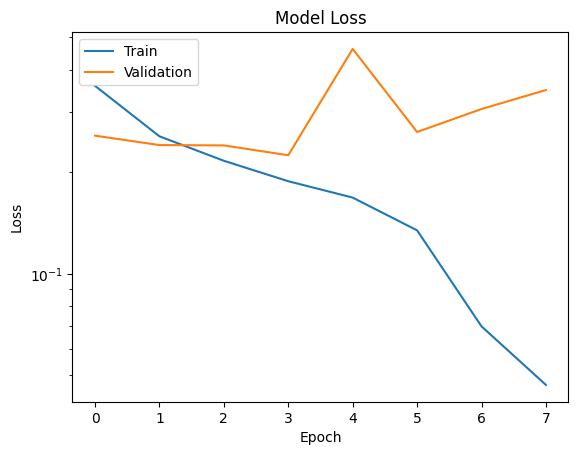

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.yscale('log')
plt.show()


In [11]:
model.load_weights('/content/wt.weights.h5')
model.evaluate(val_dataset)


145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9093 - loss: 0.2192


[0.22354720532894135, 0.9118534326553345]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


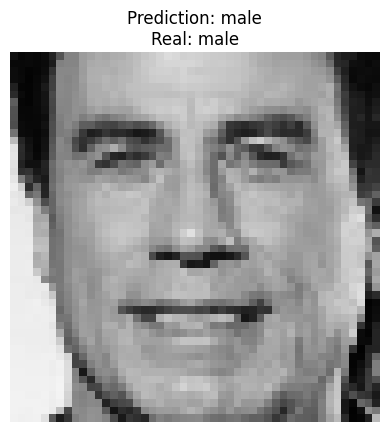

In [15]:
name_genders = ['male', 'female']
images, labels = val_dataset[100]
index = 0

p = model.predict(images)
gender_predictions = tf.where(p > 0.1, 1, 0)

plt.title(f'Prediction: {name_genders[gender_predictions[index][0]]}\nReal: {name_genders[int(labels[index])]}')
plt.imshow(images[index])
plt.axis('off')
plt.show()
